# Statistik-Projekt HS25 – Deskriptive Statistik
## Notebook 2: Lage, Streuung und Verteilungen

**Ziel:** Detaillierte statistische Beschreibung der Verspätungsdaten (Ankunft und Abfahrt).
**Methode:** Nutzung von **Polars** für High-Performance-Berechnungen auf dem Gesamtdatensatz (66 Mio. Zeilen) und Sampling für Visualisierungen.

**Inhalt:**
1. Datenimport & Feature Engineering (Polars)
2. Univariate Analyse: Lage- und Streuungsmasse (Robust vs. Klassisch)
3. Verteilungsform (Schiefe, Wölbung)
4. Ausreisser-Identifikation (Tukey-Methode)
5. Visualisierung (Histogramme, Boxplots, ECDF)

In [1]:
import polars as pl
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# Plotting-Style
sns.set_context("talk")
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# Datei-Pfad
DATA_PATH = Path("../data/processed/istdata_trains_clean.parquet")

In [2]:
print(f"Lade Daten von: {DATA_PATH}")

# 1. LazyFrame initialisieren
q = pl.scan_parquet(DATA_PATH)

# 2. Schema prüfen: Fehlt 'Wochentag'? Wenn ja, erstellen wir ihn.
# Wir holen kurz das Schema (kostet fast keine Zeit)
schema = q.collect_schema()

if "Wochentag" not in schema.names():
    print("Spalte 'Wochentag' nicht gefunden. Wird aus 'BETRIEBSTAG' berechnet...")
    
    # Prüfen, ob BETRIEBSTAG ein String oder schon ein Datum ist
    if schema["BETRIEBSTAG"] == pl.String:
        # String -> Datum parsen (Format dd.mm.yyyy)
        wochentag_expr = pl.col("BETRIEBSTAG").str.strptime(pl.Date, "%d.%m.%Y").dt.strftime("%A")
    else:
        # Ist schon Datum/Timestamp
        wochentag_expr = pl.col("BETRIEBSTAG").cast(pl.Date).dt.strftime("%A")
        
    q = q.with_columns(wochentag_expr.alias("Wochentag"))

# 3. Minuten-Spalten berechnen und finale Auswahl treffen
q = (
    q
    .with_columns([
        (pl.col("delay_arrival_s") / 60).alias("delay_arrival_min"),
        (pl.col("delay_departure_s") / 60).alias("delay_departure_min")
    ])
    .select([
        "BETREIBER_NAME", "PRODUKT_ID", "Wochentag", 
        "delay_arrival_min", "delay_departure_min", "on_time"
    ])
)

# 4. Ausführen (in den RAM laden)
df = q.collect()

print(f"Daten erfolgreich geladen: {df.height:,} Zeilen, {df.width} Spalten")
print(df.head(5))

Lade Daten von: ../data/processed/istdata_trains_clean.parquet
Spalte 'Wochentag' nicht gefunden. Wird aus 'BETRIEBSTAG' berechnet...
Daten erfolgreich geladen: 4,615,140 Zeilen, 6 Spalten
shape: (5, 6)
┌─────────────────┬────────────┬───────────┬───────────────────┬─────────────────────┬─────────┐
│ BETREIBER_NAME  ┆ PRODUKT_ID ┆ Wochentag ┆ delay_arrival_min ┆ delay_departure_min ┆ on_time │
│ ---             ┆ ---        ┆ ---       ┆ ---               ┆ ---                 ┆ ---     │
│ str             ┆ cat        ┆ str       ┆ f64               ┆ f64                 ┆ bool    │
╞═════════════════╪════════════╪═══════════╪═══════════════════╪═════════════════════╪═════════╡
│ DB ZugBus       ┆ Zug        ┆ Monday    ┆ 1.9               ┆ 1.3                 ┆ false   │
│ Regionalverkehr ┆            ┆           ┆                   ┆                     ┆         │
│ Alb-…           ┆            ┆           ┆                   ┆                     ┆         │
│ DB ZugBus       ┆ Z

### 1. Deskriptive Statistik
Wir berechnen alle wichtigen Kennzahlen (Lage, Streuung, Form) für Ankunft und Abfahrt in einem Schritt.

In [3]:
# Berechnung aller Kennzahlen direkt als Polars-Ausdruck
stats = df.select([
    # --- Ankunft ---
    pl.col("delay_arrival_min").count().alias("Arr_Count"),
    pl.col("delay_arrival_min").mean().alias("Arr_Mean"),
    pl.col("delay_arrival_min").median().alias("Arr_Median"),
    pl.col("delay_arrival_min").std().alias("Arr_Std"),
    pl.col("delay_arrival_min").min().alias("Arr_Min"),
    pl.col("delay_arrival_min").max().alias("Arr_Max"),
    pl.col("delay_arrival_min").quantile(0.25).alias("Arr_Q25"),
    pl.col("delay_arrival_min").quantile(0.75).alias("Arr_Q75"),
    
    
    # --- Abfahrt ---
    pl.col("delay_departure_min").count().alias("Dep_Count"),
    pl.col("delay_departure_min").mean().alias("Dep_Mean"),
    pl.col("delay_departure_min").median().alias("Dep_Median"),
    pl.col("delay_departure_min").std().alias("Dep_Std"),
    pl.col("delay_departure_min").min().alias("Dep_Min"),
    pl.col("delay_departure_min").max().alias("Dep_Max"),
    pl.col("delay_departure_min").quantile(0.25).alias("Dep_Q25"),
    pl.col("delay_departure_min").quantile(0.75).alias("Dep_Q75"),
    
])

# Werte für spätere Zellen extrahieren
s = stats.to_dict(as_series=False) # Gibt Listen zurück
arr_q25 = s["Arr_Q25"][0]
arr_q75 = s["Arr_Q75"][0]
dep_q25 = s["Dep_Q25"][0]
dep_q75 = s["Dep_Q75"][0]

# Saubere Ausgabe
print(f"{'Kennzahl':<15} | {'Ankunft (min)':>15} | {'Abfahrt (min)':>15}")
print("-" * 50)
print(f"{'Mean':<15} | {s['Arr_Mean'][0]:15.2f} | {s['Dep_Mean'][0]:15.2f}")
print(f"{'Median':<15} | {s['Arr_Median'][0]:15.2f} | {s['Dep_Median'][0]:15.2f}")
print(f"{'Std':<15} | {s['Arr_Std'][0]:15.2f} | {s['Dep_Std'][0]:15.2f}")
print(f"{'Min':<15} | {s['Arr_Min'][0]:15.2f} | {s['Dep_Min'][0]:15.2f}")
print(f"{'Max':<15} | {s['Arr_Max'][0]:15.2f} | {s['Dep_Max'][0]:15.2f}")
print(f"{'IQR':<15} | {arr_q75 - arr_q25:15.2f} | {dep_q75 - dep_q25:15.2f}")


Kennzahl        |   Ankunft (min) |   Abfahrt (min)
--------------------------------------------------
Mean            |            0.83 |            1.35
Median          |            0.62 |            1.08
Std             |           10.24 |           11.54
Min             |        -1440.00 |        -1440.00
Max             |          339.98 |          272.55
IQR             |            1.27 |            1.27


### 2. Ausreisser-Analyse (Tukey)
Wir berechnen die Grenzen (Fences) für milde und extreme Ausreisser und zählen die betroffenen Fahrten im Gesamtdatensatz.

In [ ]:
# IQR berechnen
arr_iqr = arr_q75 - arr_q25
dep_iqr = dep_q75 - dep_q25

# Grenzen Ankunft
arr_mild_limit = arr_q75 + 1.5 * arr_iqr
arr_extreme_limit = arr_q75 + 3.0 * arr_iqr

# Grenzen Abfahrt
dep_mild_limit = dep_q75 + 1.5 * dep_iqr
dep_extreme_limit = dep_q75 + 3.0 * dep_iqr

# Zählen der Ausreisser (Filter im gesamten Datensatz)
# Wir nutzen count() auf dem gefilterten LazyFrame für Effizienz, 
# aber da df schon im Speicher ist, geht filter().height auch super schnell.

n_arr_mild = df.filter(pl.col("delay_arrival_min") > arr_mild_limit).height
n_arr_extreme = df.filter(pl.col("delay_arrival_min") > arr_extreme_limit).height

n_dep_mild = df.filter(pl.col("delay_departure_min") > dep_mild_limit).height
n_dep_extreme = df.filter(pl.col("delay_departure_min") > dep_extreme_limit).height

total = df.height

print("--- Ausreisser ANKUNFT ---")
print(f"Grenze Mild (> {arr_mild_limit:.2f} min):    {n_arr_mild:,} ({n_arr_mild/total:.1%})")
print(f"Grenze Extrem (> {arr_extreme_limit:.2f} min):  {n_arr_extreme:,} ({n_arr_extreme/total:.1%})")

print("\n--- Ausreisser ABFAHRT ---")
print(f"Grenze Mild (> {dep_mild_limit:.2f} min):    {n_dep_mild:,} ({n_dep_mild/total:.1%})")
print(f"Grenze Extrem (> {dep_extreme_limit:.2f} min):  {n_dep_extreme:,} ({n_dep_extreme/total:.1%})")

--- Ausreißer ANKUNFT ---
Grenze Mild (> 3.22 min):    253,084 (5.5%)
Grenze Extrem (> 5.12 min):  87,071 (1.9%)

--- Ausreißer ABFAHRT ---
Grenze Mild (> 3.70 min):    261,077 (5.7%)
Grenze Extrem (> 5.60 min):  89,448 (1.9%)


### 3. Visualisierung
Für die Grafiken ziehen wir ein Zufallssample (n=250.000), da Plots mit 66 Mio. Punkten extrem langsam wären.

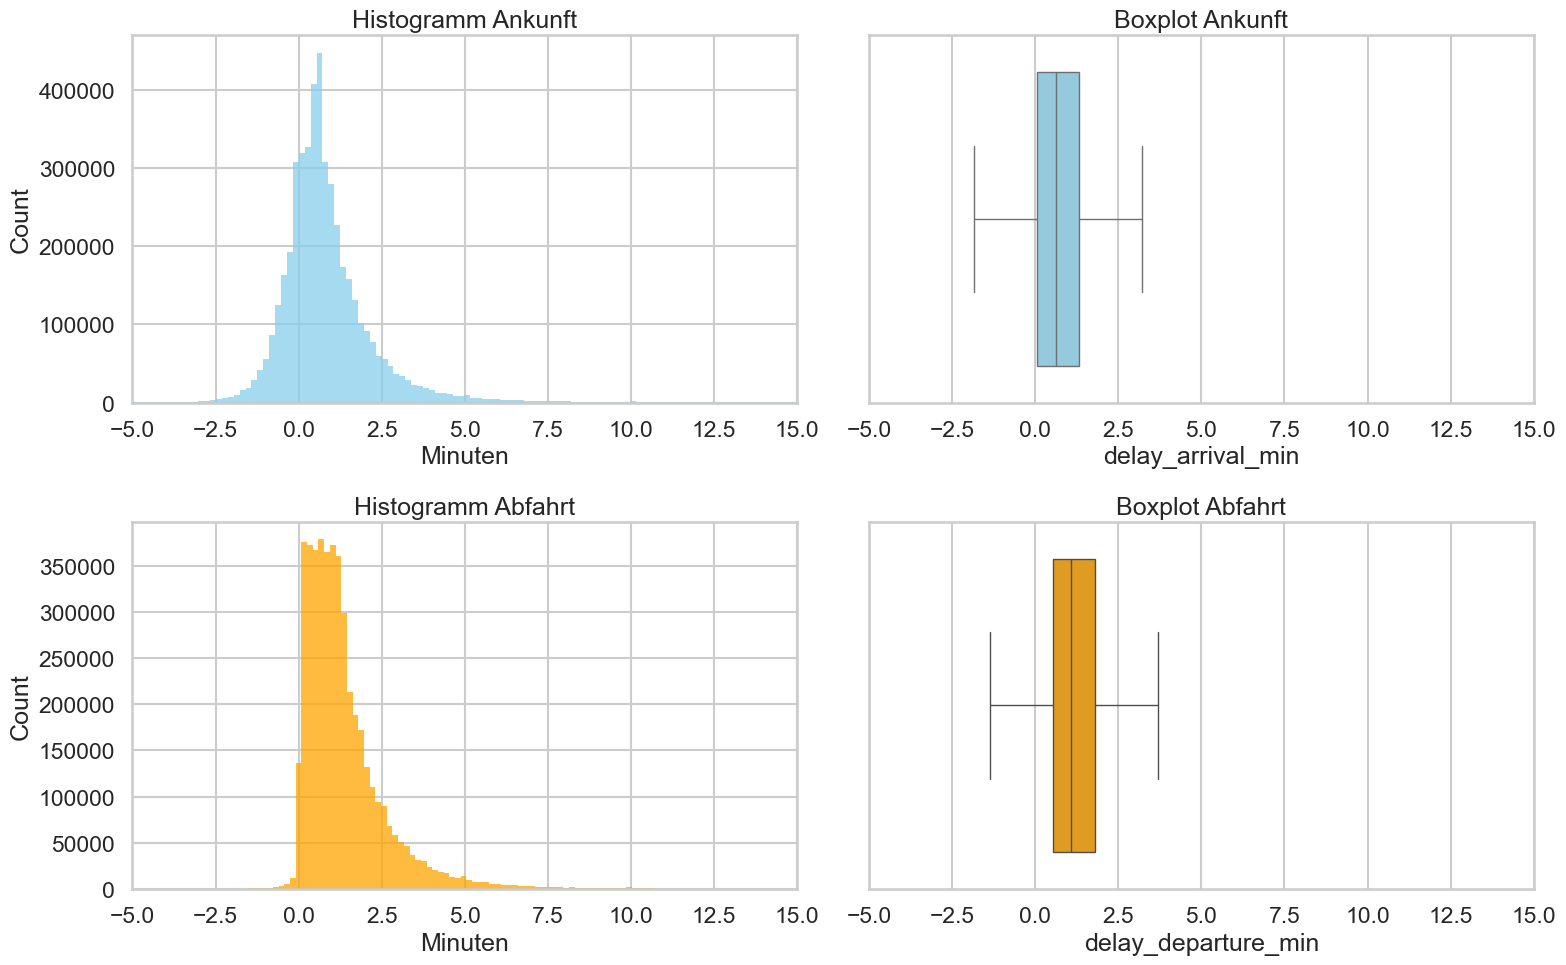

In [5]:


# Plot-Bereich für die Histogramme/Boxplots (Zoom auf den relevanten Bereich)
# Extremwerte werden für die Grafik ausgeblendet, aber in der Statistik oben berücksichtigt.
plot_range = (-5, 15)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# --- Ankunft ---
sns.histplot(df["delay_arrival_min"], bins=10000, color="skyblue", ax=axes[0,0])
axes[0,0].set_title("Histogramm Ankunft")
axes[0,0].set_xlim(plot_range)
axes[0,0].set_xlabel("Minuten")

sns.boxplot(x=df["delay_arrival_min"], color="skyblue", showfliers=False, ax=axes[0,1])
axes[0,1].set_title("Boxplot Ankunft")
axes[0,1].set_xlim(plot_range)

# --- Abfahrt ---
sns.histplot(df["delay_departure_min"], bins=10000, color="orange", ax=axes[1,0])
axes[1,0].set_title("Histogramm Abfahrt")
axes[1,0].set_xlim(plot_range)
axes[1,0].set_xlabel("Minuten")

sns.boxplot(x=df["delay_departure_min"], color="orange", showfliers=False, ax=axes[1,1])
axes[1,1].set_title("Boxplot Abfahrt")
axes[1,1].set_xlim(plot_range)

plt.tight_layout()
plt.show()

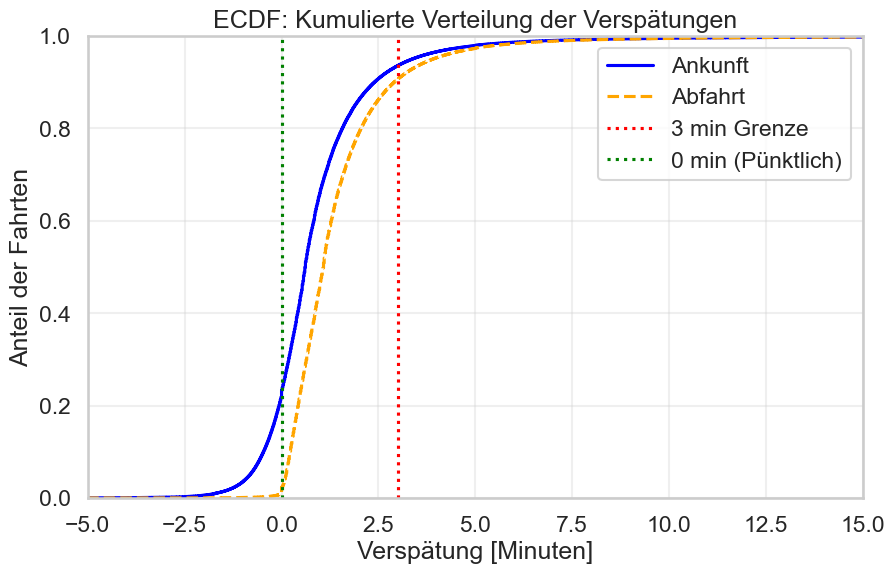

In [6]:
# ECDF Plot (Empirische Verteilungsfunktion)
df_viz = df.select(["delay_arrival_min", "delay_departure_min"]).to_pandas()
plt.figure(figsize=(10, 6))
sns.ecdfplot(data=df_viz, x="delay_arrival_min", label="Ankunft", color="blue")
sns.ecdfplot(data=df_viz, x="delay_departure_min", label="Abfahrt", color="orange", linestyle="--")

# Linien für Pünktlichkeitsschwelle (z.B. 3 Minuten)
plt.axvline(3, color='red', linestyle=':', label="3 min Grenze")
plt.axvline(0, color='green', linestyle=':', label="0 min (Pünktlich)")

plt.xlim(-5, 15)
plt.title("ECDF: Kumulierte Verteilung der Verspätungen")
plt.xlabel("Verspätung [Minuten]")
plt.ylabel("Anteil der Fahrten")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()